In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.integrate as integrate

%matplotlib inline


/Users/qichaohuang/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
#short rate process:
#dr(t)=mu*dt+vol*dW(t) 
r0 = 0.0135
mu = 0.005
vol = 0.005
var = pow(vol,2)

x = range(1,21)
term = [xx/4. for xx in x]

def mu_t(t):
    return mu

def integrated_mu(t):
    result = integrate.quad(lambda x: mu_t(x), 0,t)
    return result[0]

def mean_r(t,dist = 'Q'): 
    m = r0+mu*t
    if (dist == 'F'):
        m -= var * pow(t,2)
    return m

#int{r(u)du}:
def mean_int_r(t):
    return r0*t+mu*pow(t,2)/2.

def var_int_r(t):
    return var*pow(t,3)/3


In [4]:
def A(tau):
    return var*pow(tau,3)/6. - mu*pow(tau,2)/2.

def B(tau):
    return tau

def zero(t0,T,r_t0):
    tau = T-t0
    return np.exp(A(tau)-B(tau)*r_t0)



In [5]:
def fwd_rate(t_fix,T0,T1,dist = 'Q', acrual=0.25):
    A_diff = A(T0-t_fix) - A(T1-t_fix)
    B_diff = B(T0-t_fix) - B(T1-t_fix)
    m = A_diff - B_diff * mean_r(t_fix,dist)
    v = var * t_fix * pow(B_diff,2)
    e = np.exp(m+v/2.)
    return 1/acrual * (e-1)

def fwd_rate_mean(t_fix,T0,T1,dist='Q',acrual=0.25):
    m1 = mgf(t_fix,T0,T1,1,dist)
    return 1/acrual*(m1-1)

def fwd_rate_vol(t_fix,T0,T1,dist='Q',acrual=0.25):
    m2 = mgf(t_fix,T0,T1,2,dist)
    m1 = mgf(t_fix,T0,T1,1,dist)
    e2 = m2 - pow(m1,2)
    return 1/acrual*pow(e2/t_fix,0.5)


In [6]:
def mgf(t_fix,T0,T1,k,dist = 'Q'):
    A_diff = A(T0-t_fix) - A(T1-t_fix)
    B_diff = B(T0-t_fix) - B(T1-t_fix)
    m = A_diff - B_diff * mean_r(t_fix,dist)
    v = var * t_fix * pow(B_diff,2)
    return np.exp(k*(2*m+k*v)/2.)

In [7]:
n=10000
def fwd_rate_MC(T,mean_R,var_R,n,acrual=0.25):
    rt=np.random.normal(mean_R,var_R,n)
    zf = [zero(T,T+acrual,r) for r in rt]
    rate = [1./acrual*(1./zp-1) for zp in zf]
    return np.mean(rate)

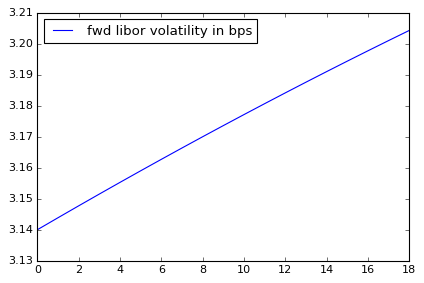

In [8]:
vol = [fwd_rate_vol(t,t,t+0.25,'F')*10000/16 for t in range(1,20)]
plt.plot(vol, label = 'fwd libor volatility in bps')
plt.legend(loc = 'best')
plt.show()

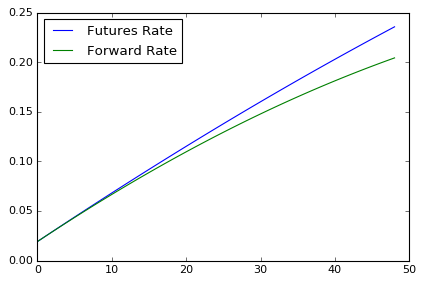

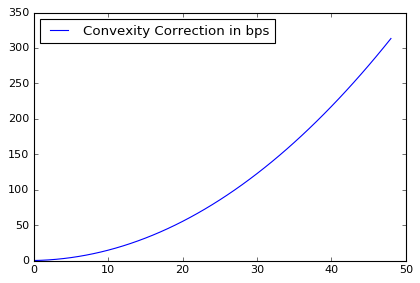

In [9]:
#rate_Q_MC = [fwd_rate_MC(t,mean_r(t),var*t,n) for t in range(1,50)]
#rate_F_MC = [fwd_rate_MC(t,mean_r(t)-var*t*B(t),var*t,n) for t in range(1,50)]
rate_Q = [fwd_rate(0,t,t+0.25,'Q') for t in range(1,50)]
rate_F = [fwd_rate(t,t,t+0.25,'F') for t in range(1,50)]

cc = [(l - f)*10000 for l,f in zip(rate_Q,rate_F)]
plots = [plt.plot(rate_Q, label = 'Futures Rate'), plt.plot(rate_F, label = 'Forward Rate')]
plt.legend(loc = 'best')
plt.show()
plt.plot(cc, label = 'Convexity Correction in bps')
plt.legend(loc = 'best')
plt.show()

In [145]:
di='/Users/edith/Python/Data/'
fl = 'closes_Quandl_Rolling_EDs.csv'
df = pd.read_csv(di+fl)
df = df.set_index(['Date'])
df.index = pd.to_datetime(df.index)

d1 = '2006-02-09'
df = df[df.index > d1]
df = df.rename(columns=lambda x: x.split('_')[1], inplace=False)
#df2.tail(2)
#df2['ED18'].plot()
#plt.legend(loc='best')
print (df.loc['2017-03-14'])



ED1     1.350
ED2     1.495
ED3     1.650
ED4     1.785
ED5     1.935
ED6     2.070
ED7     2.205
ED8     2.295
ED9     2.380
ED10    2.460
ED11    2.550
ED12    2.600
ED13    2.645
ED14    2.690
ED15    2.750
ED16    2.785
ED17    2.820
ED18    2.860
ED19    2.910
ED20    2.940
Name: 2017-03-14 00:00:00, dtype: float64


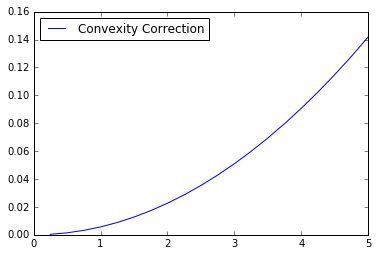

In [146]:
x = range(1,21)
term = [xx/4. for xx in x]
rate_Q = [fwd_rate(t,t,t+0.25,'Q')*100 for t in term]
rate_F = [fwd_rate(t,t,t+0.25,'F')*100 for t in term]
cc = [r1-r2 for r1,r2 in zip(rate_Q, rate_F)]
plt.plot(term, cc, label = 'Convexity Correction')
plt.legend(loc = 'upper left')

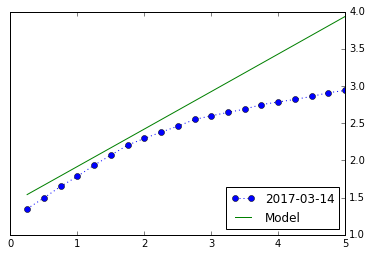

In [147]:
def plot2(dt,frame,x,y):
    f = plt.figure()
    ax = f.add_subplot(111)
    ax.yaxis.tick_right()  
    crv = frame.loc[dt]
    plots = [plt.plot(x,crv.values,label=dt,linestyle="dotted",marker='o'),plt.plot(x,y,label='Model')]
    plt.legend(loc='lower right')    
    plt.show()
    
dt = '2017-03-14'
plot2(dt,df,term,rate_Q)



In [148]:
df.tail(2)

,ED1,ED2,ED3,ED4,ED5,ED6,ED7,ED8,ED9,ED10,ED11,ED12,ED13,ED14,ED15,ED16,ED17,ED18,ED19,ED20
Date,,,,,,,,,,,,,,,,,,,,
2017-04-03,1.285,1.425,1.525,1.62,1.73,1.835,1.95,2.02,2.09,2.155,2.240,2.285,2.335,2.38,2.44,2.475,2.515,2.56,2.61,2.645
2017-04-04,1.285,1.425,1.520,1.61,1.72,1.825,1.94,2.01,2.08,2.145,2.225,2.270,2.325,2.37,2.43,2.465,2.505,2.55,2.60,2.635
